<a href="https://colab.research.google.com/github/mlacasa/economy/blob/main/TFG_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import itertools

# Crear fichero distribución de salarios para trabajar

https://sede.agenciatributaria.gob.es/Sede/datosabiertos/catalogo/hacienda/Informes_anuales_de_Recaudacion_Tributaria.shtml


## Se carga sólo salarios

Se carga salarios y se convierte en 1 columna salarios, otra columna, años.

Cada año contiene 399 filas.

de 2001-2021 -> 21 años.


### información sobre la base de datos

Distribución de los salarios de la estadística Mercado
de Trabajo y Pensiones en las Fuentes Tributarias:
nota metodológica

La estadística Mercado de Trabajo y Pensiones en las Fuentes Tributarias es
una investigación de carácter censal basada en las declaraciones anuales del
modelo 190 (Declaración Resumen Anual de Retenciones e Ingresos a Cuenta
sobre Rendimientos del Trabajo, de determinadas actividades económicas,
premios y determinadas imputaciones de renta), cuyo objetivo es el análisis de
los principales colectivos representados en ese modelo (asalariados,
desempleados y pensionistas).

El marco poblacional está constituido por todas las empresas y entidades
que pagan salarios. Estas empresas y entidades están obligadas a
presentar el modelo 190 con la respectiva relación de perceptores de
dichos salarios. Hay que recordar que entre las unidades informantes no
están los hogares que pagan salarios a empleados del hogar.

Son asalariados aquellos perceptores cuyas percepciones están
declaradas en la clave A (empleados por cuenta ajena), que incluye todas
aquellas percepciones, dinerarias o en especie, que hayan sido satisfechas
por la persona o entidad declarante en concepto de rendimientos del
trabajo.

La referencia anual para la definición de la población asalariada y la
existencia de situaciones de pluriempleo y de relaciones laborales de
duración inferior al año hace posible que un asalariado obtenga a lo largo
del año percepciones salariales de dos o más empresas o entidades. El
salario anual de cada asalariado es la suma de todas las percepciones
salariales recibidas por el mismo y pagadas por una o más empresas o
entidades.

En este sentido conviene recordar que la distribución de los asalariados no
tiene la forma que teóricamente se presume, sino que, por el contrario, tiene
como rasgo característico una cola inferior muy pronunciada. Este rasgo se
deriva del hecho de que los asalariados incluidos en la estadística son todos
los que han recibido alguna remuneración salarial, independientemente del
tiempo trabajado; de ahí que todos los asalariados que no han trabajado todo el
año o gran parte del mismo se acumulen en esa parte inferior de la distribución.

In [ ]:
# Cargo la dataset de "Salarios"
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFG/salarios.csv" , delimiter = ';')

In [ ]:
# Creo una columna con los años (400 filas de cada uno de los 21 años)

years = []
for i in np.arange(2001,2022,1):                # en np.arange primer incluye, pero último no incluye sería [)
    years.extend(list(itertools.repeat(i,400)))
len(years)

8400

In [ ]:
# Creo una lista con las franjas repetidas 21 veces, una por cada año.
franja = list(df['franja'])
franja = franja*21
len(franja)

8400

In [ ]:
# Creo una lista con las columnas de los años.
cols = list(df.columns)
cols = cols[:-1]
cols = cols[1:] # elimino la primera

# Ahora genero una única columna de los 21 años.

df1 = df['2001']
for c in cols:
  df1 = pd.concat([df1, df[c]])
df1.shape

(8400,)

In [ ]:
salarios = pd.DataFrame()
salarios['years'] = years
salarios['range'] = franja
salarios['incomes'] = list(df1)

In [ ]:
# Ahora se trata de ir añadiendo el resto de columnas.
# Retenciones
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFG/retenciones.csv" , delimiter = ';')

In [ ]:
df1 = df['2001']
for c in cols:
  df1 = pd.concat([df1, df[c]])
df1.shape
salarios['taxes'] = list(df1)

In [ ]:
# numero de asalariados
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFG/employees.csv" , delimiter = ';')

In [ ]:
df1 = df['2001']
for c in cols:
  df1 = pd.concat([df1, df[c]])
df1.shape
salarios['employees'] = list(df1)

In [ ]:
#Creamos la columna MeanIncome

salarios['MeanIncome'] = round(salarios['incomes']/salarios['employees'],0)

In [ ]:
salarios['years'] = pd.to_datetime(salarios['years'], format='%Y')

In [ ]:
salarios.tail()

,years,range,incomes,taxes,employees,MeanIncome
8395,2021-01-01,79100,2.130911e+08,5.997367e+07,2694,79098.0
8396,2021-01-01,79300,2.103814e+08,5.936772e+07,2653,79299.0
8397,2021-01-01,79500,2.074963e+08,5.892348e+07,2610,79500.0
8398,2021-01-01,79700,2.057813e+08,5.812752e+07,2582,79698.0
8399,2021-01-01,80000,4.172739e+10,1.431242e+10,323219,129099.0


In [ ]:
# Creo dataset con la estructura definida.
#salarios.to_csv('/content/drive/MyDrive/Colab Notebooks/TFG/DistribSalarios.csv')

# A partir de aquí calculamos índice GINI

Explicación: https://www.bbva.com/es/coeficiente-gini-detector-la-desigualdad-salarial/

Fórumlas aplicadas a la 2a función:

Índice: ![Imagen](https://www.statsdirect.com/help/generatedimages/equations/equation154.svg)

## PASOS

1- De cada año se calcula un vector para el cálculo del índice Gini.\
2- De cada franja, existe un valor medio * nº asalariados.\
3- El vector refleja el nº de personas con ese valor medio.\
4- Se aplica el índice Gini de cada vector.

Evaluamos el índice Gini por salario bruto y neto (para obervar el efecto de reditribución mediante impuesto progresivo).

In [ ]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array = array + 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [ ]:
# Cargamos Dataset Salarios

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFG/DistribSalarios.csv")

# Convertimos years -> a un valor entero, año.

df['years'] = pd.to_datetime(df['years'])
df['years'] = df['years'].dt.year
# Generamos NetIncomes
df['NetIncomes'] = df['incomes'] - df['taxes']
df['MeanNetIncomes'] = round(df['NetIncomes']/df['employees'],0)

In [ ]:
df.head()

,Unnamed: 0,years,range,incomes,taxes,employees,MeanIncome,NetIncomes,MeanNetIncomes
0,0,2001,100,2.954162e+07,642479.99,308133,96.0,2.889914e+07,94.0
1,1,2001,300,7.296563e+07,1434009.97,244429,299.0,7.153162e+07,293.0
2,2,2001,500,1.183979e+08,2271731.26,236520,501.0,1.161262e+08,491.0
3,3,2001,700,1.492884e+08,2761998.29,214001,698.0,1.465264e+08,685.0
4,4,2001,900,1.878292e+08,3396991.08,208735,900.0,1.844322e+08,884.0


In [ ]:
# Generamos tablas de las 3 variables para generar los vectores de cada año
y = np.arange(2001,2022,1)                                                          # Vector de columnas, por años
Employees = df.pivot(index='range', columns='years', values=['employees'])          # pivot por los 3 valores para índice Gini.
Employees.columns = y
MeanIncome = df.pivot(index='range', columns = 'years', values = ['MeanIncome'])
MeanIncome.columns = y
MeanNetIncomes = df.pivot(index='range', columns='years', values=['MeanNetIncomes'])
MeanNetIncomes.columns = y

In [ ]:
vect = []                                                                                   # De cada año (vect)
for i in range(400):                                                                        # de cada fila (rango)
  vect.extend([np.array(int(MeanIncome.iloc[i,0])).tolist()]*int(Employees.iloc[i,0]))      # valor medio/rango * nº empleados/rango -> len(vect) = nº declarantes

In [ ]:
# Calculo Índice Gini del vector Gross Salary
Grossgini = []
EmployeesY = []
n = 0
while n < 21:                                                                             # n para cada año
  l = []
  for i in range(400):                                                                    # i para cada rango
    l.extend([np.array(int(MeanIncome.iloc[i,n])).tolist()]*int(Employees.iloc[i,n]))     # iloc[i,n] cada fila -> rango y cada col -> n año
  r = round(gini(np.array(l)),3)                                                                      # Se ejecuta la fórmula gini
  EmployeesY.append(len(l))                                                               # Guardo vector asalariados/año
  print('Índice Gini del año', 2001+n, 'es: ',r, 'nº asalariados ',len(l))
  Grossgini.append(r)                                                                     # Guardo ese Gini de ese año
  n = n+1

Índice Gini del año 2001 es:  0.465 nº asalariados  15871355
Índice Gini del año 2002 es:  0.462 nº asalariados  16437857
Índice Gini del año 2003 es:  0.463 nº asalariados  17001430
Índice Gini del año 2004 es:  0.457 nº asalariados  17320764
Índice Gini del año 2005 es:  0.462 nº asalariados  18359870
Índice Gini del año 2006 es:  0.459 nº asalariados  19070349
Índice Gini del año 2007 es:  0.448 nº asalariados  19309032
Índice Gini del año 2008 es:  0.453 nº asalariados  19310627
Índice Gini del año 2009 es:  0.466 nº asalariados  18451827
Índice Gini del año 2010 es:  0.467 nº asalariados  18024554
Índice Gini del año 2011 es:  0.469 nº asalariados  17788121
Índice Gini del año 2012 es:  0.472 nº asalariados  17063142
Índice Gini del año 2013 es:  0.482 nº asalariados  16682062
Índice Gini del año 2014 es:  0.483 nº asalariados  16899024
Índice Gini del año 2015 es:  0.483 nº asalariados  17349558
Índice Gini del año 2016 es:  0.483 nº asalariados  17888520
Índice Gini del año 2017

In [ ]:
# Calculo Índice Gini del vector Net Salary
Netgini = []
n = 0
while n < 21:                                                                             # n para cada año
  l = []
  for i in range(400):                                                                    # i para cada rango
    l.extend([np.array(int(MeanNetIncomes.iloc[i,n])).tolist()]*int(Employees.iloc[i,n]))     # iloc[i,n] cada fila -> rango y cada col -> n año
  r = round(gini(np.array(l)),3)                                                                   # Se ejecuta la fórmula gini
  print('Índice Gini del año', 2001+n, 'es: ',r, 'nº asalariados ',len(l))
  Netgini.append(r)                                                                     # Guardo ese Gini de ese año
  n = n+1

Índice Gini del año 2001 es:  0.424 nº asalariados  15871355
Índice Gini del año 2002 es:  0.421 nº asalariados  16437857
Índice Gini del año 2003 es:  0.423 nº asalariados  17001430
Índice Gini del año 2004 es:  0.416 nº asalariados  17320764
Índice Gini del año 2005 es:  0.422 nº asalariados  18359870
Índice Gini del año 2006 es:  0.418 nº asalariados  19070349
Índice Gini del año 2007 es:  0.406 nº asalariados  19309032
Índice Gini del año 2008 es:  0.411 nº asalariados  19310627
Índice Gini del año 2009 es:  0.424 nº asalariados  18451827
Índice Gini del año 2010 es:  0.426 nº asalariados  18024554
Índice Gini del año 2011 es:  0.428 nº asalariados  17788121
Índice Gini del año 2012 es:  0.427 nº asalariados  17063142
Índice Gini del año 2013 es:  0.437 nº asalariados  16682062
Índice Gini del año 2014 es:  0.439 nº asalariados  16899024
Índice Gini del año 2015 es:  0.44 nº asalariados  17349558
Índice Gini del año 2016 es:  0.439 nº asalariados  17888520
Índice Gini del año 2017 

## Se crea un cálculo de los percentiles por años.

Se requiere cargar los datos anteriores para crear "MeanIncome"

In [ ]:
from scipy.stats import percentileofscore
smi = [505.7, 515.9, 526.4, 537.3, 598.5, 631.1, 665.7, 700, 728, 738.9, 748.3, 748.3, 752.9, 752.9, 756.7, 764.4, 825.7, 858.6, 1050, 1108.3, 1108.3 ]
percent = []
score = []
n = 0
while n < 21:                                                                             # n para cada año
  l = []
  for i in range(400):                                                                    # i para cada rango
    l.extend([np.array(int(MeanIncome.iloc[i,n])).tolist()]*int(Employees.iloc[i,n]))     # iloc[i,n] cada fila -> rango y cada col -> n año
  r = np.percentile(l, np.arange(0,100,10))
  percent.append(r)
  s = round(percentileofscore(l, smi[n]*12), 1)
  score.append(s)
  n = n+1

In [ ]:
per = pd.DataFrame(percent, index = y, columns = ['0th', '10th', '20th', '30th', '40th' ,'50th', '60th', '70th', '80th', '90th'])
smi = [505.7, 515.9, 526.4, 537.3, 598.5, 631.1, 665.7, 700, 728, 738.9, 748.3, 748.3, 752.9, 752.9, 756.7, 764.4, 825.7, 858.6, 1050, 1108.3, 1108.3 ]
per['NMW'] = [v * 12 for v in smi]
per['Percentile/NMW'] = score
per

,0th,10th,20th,30th,40th,50th,60th,70th,80th,90th,NMW,Percentile/NMW
2001,96.0,1297.0,3697.0,6500.0,9096.0,11100.0,13098.0,16099.0,20697.0,28302.0,6068.4,28.4
2002,95.0,1499.0,3900.0,6699.0,9303.0,11500.0,13499.0,16700.0,21498.0,29101.0,6190.8,28.3
2003,93.0,1499.0,3900.0,6900.0,9700.0,12097.0,14098.0,17299.0,22300.0,30298.0,6316.8,28.2
2004,94.0,1699.0,4300.0,7500.0,10299.0,12500.0,14699.0,18092.0,23293.0,31499.0,6447.6,26.5
2005,94.0,1700.0,4299.0,7293.0,10500.0,12900.0,15097.0,18499.0,23901.0,32497.0,7182.0,29.3
2006,94.0,1699.0,4700.0,7903.0,11100.0,13500.0,15900.0,19500.0,24900.0,33900.0,7573.2,28.8
2007,94.0,2300.0,5700.0,9096.0,12093.0,14495.0,17099.0,20700.0,26499.0,35900.0,7988.4,27.0
2008,96.0,2300.0,5700.0,9095.0,12500.0,15097.0,18091.0,21899.0,28097.0,38097.0,8400.0,27.8
2009,97.0,1898.0,4899.0,8496.0,12089.0,15096.0,18299.0,22498.0,28899.0,39300.0,8736.0,30.8
2010,97.0,1898.0,4699.0,8496.0,12088.0,15300.0,18498.0,22700.0,29098.0,39100.0,8866.8,31.0


In [ ]:
# Añado a la dataset macro
macro = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFG/macro.csv")
macro['Percentile'] = list(per['Percentile/NMW'])
macro.head()

,Unnamed: 0.1,Unnamed: 0,years,nmw,Grossgini,Netgini,employees,uneRate,Pdebt,Pdebt_GDP,GDP,MeanSalaryR,MeanSalary,Diff,IPC,taxes,Percentile
0,0,0,2001,505.7,0.465,0.424,15871355,10.94,378883,54.0,700993,20200.0,13932.0,6268.0,6.55,3.158375e+10,28.4
1,1,1,2002,515.9,0.462,0.421,16437857,11.55,384145,51.2,749552,20533.0,14370.0,6163.0,-0.53,3.465064e+10,28.3
2,2,2,2003,526.4,0.463,0.423,17001430,11.99,382775,47.7,802266,21021.0,14963.0,6058.0,0.79,3.562756e+10,28.2
3,3,3,2004,537.3,0.457,0.416,17320764,11.50,389888,45.4,859437,21403.0,15658.0,5745.0,1.18,3.897150e+10,26.5
4,4,4,2005,598.5,0.462,0.422,18359870,10.17,393479,42.4,927357,21865.0,16018.0,5847.0,1.11,4.318983e+10,29.3


In [ ]:
macro.to_csv("/content/drive/MyDrive/Colab Notebooks/TFG/macro.csv") #Se incorpora la columna Percentile (que es el percentil sobre la serie de salarios del SMI)

## Se crea un dataframe donde cada año/Gini Index/SMI

Los valores SMI de la web datos.macro


In [ ]:
smi = [505.7, 515.9, 526.4, 537.3, 598.5, 631.1, 665.7, 700, 728, 738.9, 748.3, 748.3, 752.9, 752.9, 756.7, 764.4, 825.7, 858.6, 1050, 1108.3, 1108.3 ]
years = np.arange(2001, 2022, 1)
unemployment = [10.94, 11.55, 11.99, 11.5, 10.17, 9.03, 8.42, 9.6, 17.24, 19.84, 21.08, 24.19, 26.94, 25.93, 23.78, 21, 18.75, 14.70, 16.74, 14.41, 15.98]
deuda = [1427238,1345786,1223355,1208861,1183412,1145050,1113661,1084846,1025655,927813,743043,649153,569535,440621,384662,392132,393479,389888,382775,384145,378883]
deudaPIB = [118.30,120.40,98.20,100.40,101.80,102.70,103.30,105.10,100.50,90.00,69.90,60.50,53.30,39.70,35.80,39.10,42.40,45.40,47.70,51.20,54.00]
PIB = [1206842,1117989,1245513,1203859,1162492,1114420,1078092,1032608,1020677,1031104,1063763,1072709,1069323,1109541,1075539,1003823,927357,859437,802266,749552,700993]
IPC = [6.55,-0.53,0.79,1.18,1.11,1.57,0.02,-1.04,0.25,2.87,2.38,2.99,0.79,1.43,4.22,2.67,3.74,3.23,2.6,4,2.71]

In [ ]:
deuda.reverse()
deudaPIB.reverse()
PIB.reverse()

In [ ]:
macro = pd.DataFrame()
macro['years'] = years
macro['nmw'] = smi                # National Minimum Wage
macro['Grossgini'] = Grossgini    # Gross Salary Gini Index
macro['Netgini'] = Netgini        # Net Salary Gini Index
macro['employees'] = EmployeesY   # Asalariados declarantes
macro['uneRate'] = unemployment   # Sólo 1T de cada año, fuente: https://www.ine.es/prensa/epa_tabla.htm
macro['Pdebt'] = deuda            # datos macro
macro['Pdebt_GDP'] = deudaPIB     # Datos macro
macro['GDP'] = PIB                # Datos macro
macro['IPC'] = IPC                # IPC a diciembre INE


NameError: ignored

In [ ]:
# macro.to_csv("/content/drive/MyDrive/Colab Notebooks/TFG/macro.csv") Se ha actualizado abajo.

In [ ]:
pip install pingouin

In [ ]:
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y análisis
# ==============================================================================
import statsmodels.api as sm
import pingouin as pg
from scipy import stats
from scipy.stats import pearsonr

# Configuración matplotlib
# ==============================================================================
plt.style.use('ggplot')

Text(0, 0.5, 'Gini')

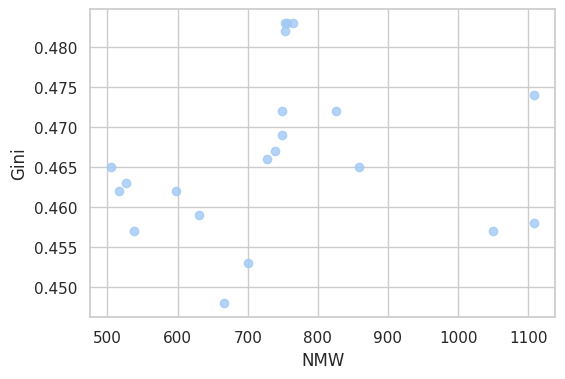

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(x=macro.nmw, y=macro.Grossgini, alpha= 0.8)
ax.set_xlabel('NMW')
ax.set_ylabel('Gini')

In [ ]:
macro['nmw'].corr(macro['gini'], method='spearman')

0.37439081817777486

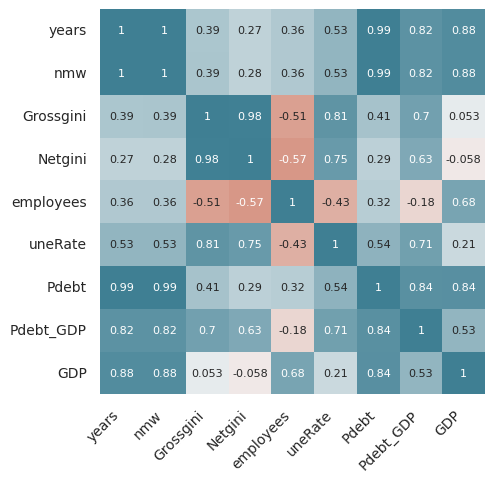

In [ ]:

# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(
    macro.corr(method='spearman'),
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

# MEAN SALARY DIFFERENCE EXPLAINED

## Evolución nº trabajadores por franja

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFG/DistribSalarios.csv")
# Selecciono sólo año 2001-2008-2021
df1 = df[(df['years'] == '2001-01-01') | (df['years'] == '2008-01-01') | (df['years'] == '2021-01-01') ]
df1['years'] = pd.to_datetime(df1['years'])
df1['years'] = df1['years'].dt.year

<ipython-input-2-6785d8283c26>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['years'] = pd.to_datetime(df1['years'])
<ipython-input-2-6785d8283c26>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['years'] = df1['years'].dt.year


In [ ]:
df1.head()

,Unnamed: 0,years,range,incomes,taxes,employees,MeanIncome
0,0,2001,100,2.954162e+07,642479.99,308133,96.0
1,1,2001,300,7.296563e+07,1434009.97,244429,299.0
2,2,2001,500,1.183979e+08,2271731.26,236520,501.0
3,3,2001,700,1.492884e+08,2761998.29,214001,698.0
4,4,2001,900,1.878292e+08,3396991.08,208735,900.0


[Text(0.5, 0, '[€0-200]                                                                 200€ Intervals                                                        [ €79,700-79,900], [ >80,000]')]

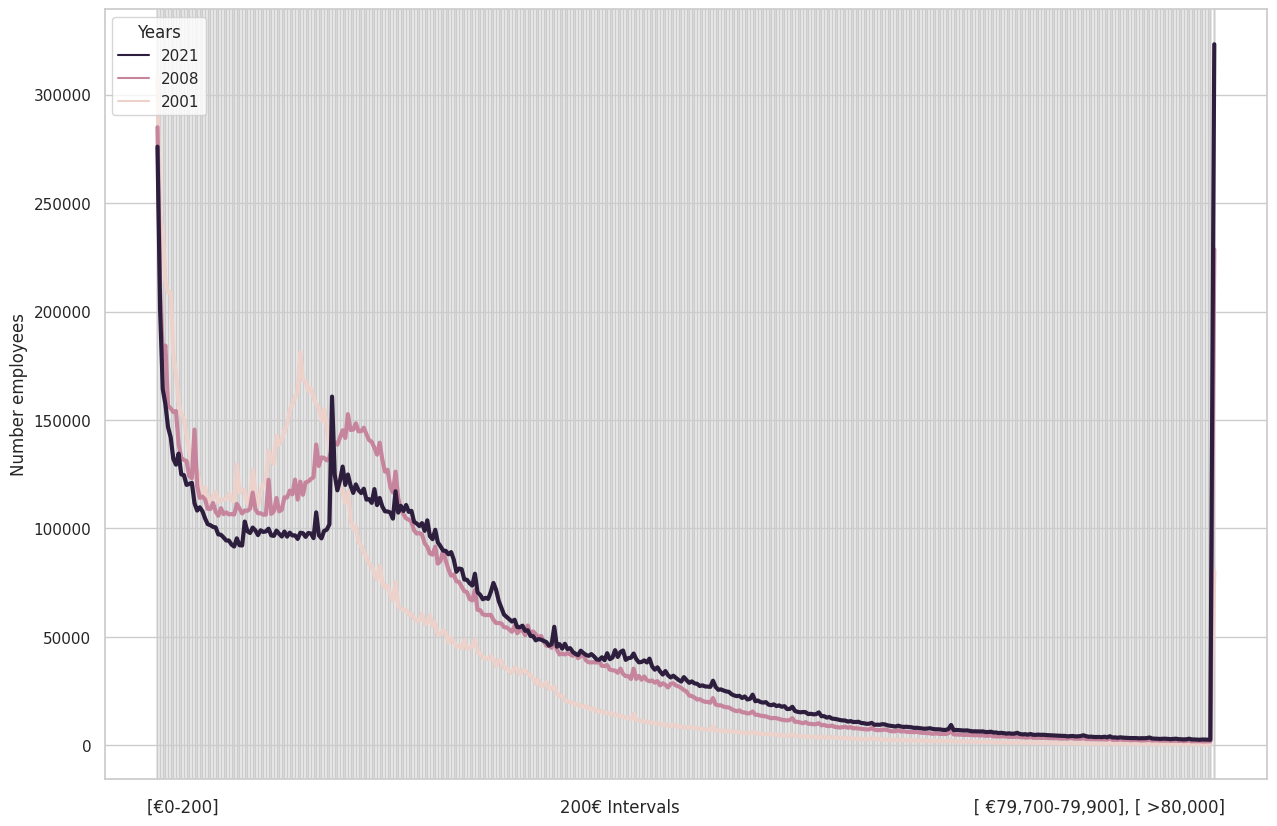

In [ ]:
# Muestro evolución de los distintos años
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_theme(style="whitegrid", palette="ch:start=.9,rot=-.1")
sns.lineplot(data=df1, x="range", y="employees", hue='years', linewidth=3)
ax.set(xticks=df1.range, xlabel='', ylabel='Number employees')    # Que aparezcan todos los años en X y títulos ejes.
handles, labels = ax.get_legend_handles_labels()
#labels = ['up to 20K', '20-40K', '40-60K', '60-80K', '>80K']
ax.legend(handles[::-1], labels[::-1], title='Years', loc='upper left')
ax.set(xticklabels=[])  # remove the tick labels
ax.set( xlabel = '[€0-200]                                                                 200€ Intervals                                                        [ €79,700-79,900], [ >80,000]')


# Tax Rate by Range

Tabla por años de la evolución del % que mide el grado de progresividad del IRPF

In [ ]:
RatesRange = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFG/TipusFranja.csv", delimiter=';')

In [ ]:
RatesRange

,Rate,Range,Year
0,6.09,0K,2001
1,17.67,20K,2001
2,24.49,40K,2001
3,29.31,60K,2001
4,36.00,80K,2001
...,...,...,...
100,3.64,0K,2021
101,14.90,20K,2021
102,21.44,40K,2021
103,25.85,60K,2021


In [ ]:
RatesRange[RatesRange['Year'] == 2001]

,Rate,Range,Year
0,6.09,0K,2001
1,17.67,20K,2001
2,24.49,40K,2001
3,29.31,60K,2001
4,36.00,80K,2001


In [ ]:
RatesRange[RatesRange['Year'] == 2021]

,Rate,Range,Year
100,3.64,0K,2021
101,14.90,20K,2021
102,21.44,40K,2021
103,25.85,60K,2021
104,34.00,80K,2021


In [ ]:
RatesRange['Year'] = RatesRange['Year'].astype('category')

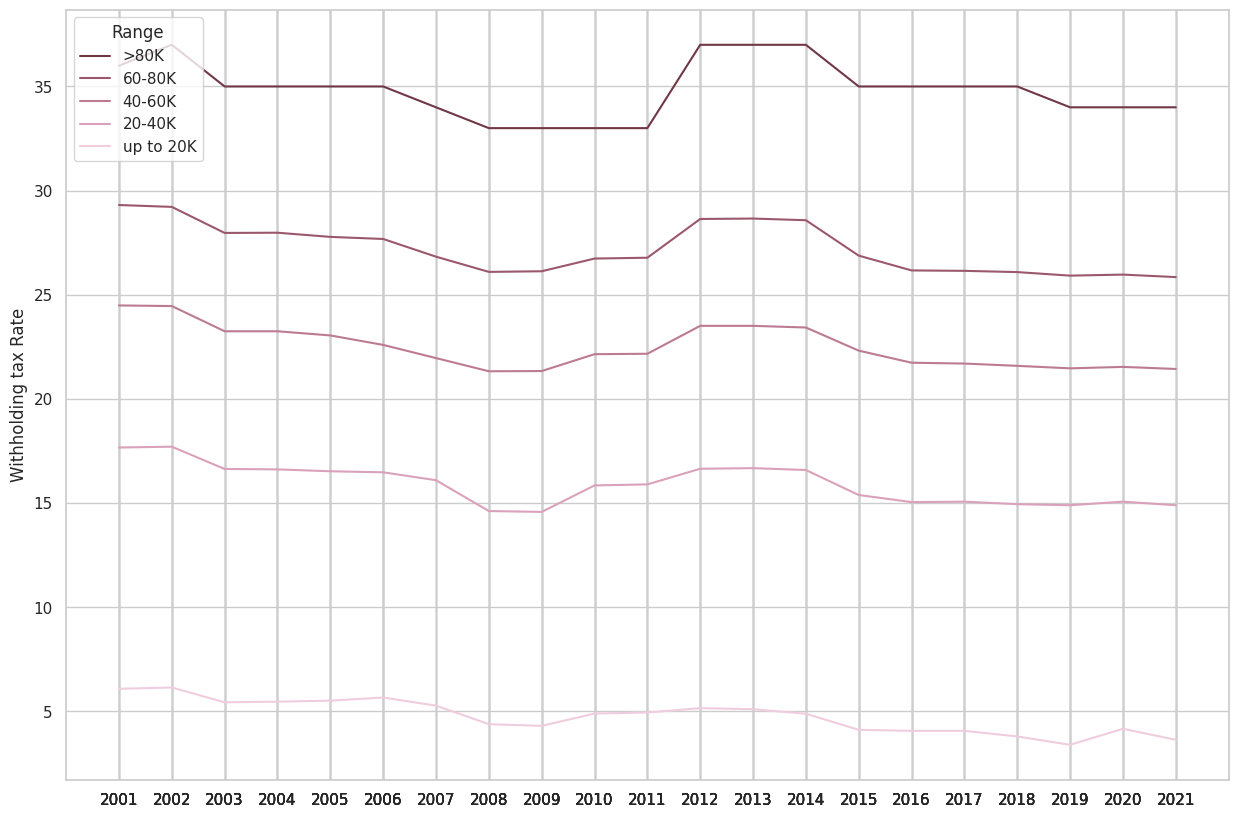

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_theme(style="whitegrid", palette="ch:start=.9,rot=-.1")
sns.lineplot(data=RatesRange, x="Year", y="Rate", hue='Range')
ax.set(xticks=RatesRange.Year, xlabel='', ylabel='Withholding tax Rate')    # Que aparezcan todos los años en X y títulos ejes.
handles, labels = ax.get_legend_handles_labels()
labels = ['up to 20K', '20-40K', '40-60K', '60-80K', '>80K']
ax.legend(handles[::-1], labels[::-1], title='Range', loc='upper left')


# Cálculo DIFF Se prepara la dataset Salary.csv

In [ ]:
# Cargamos Dataset Salarios

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFG/DistribSalarios.csv")

# Convertimos years -> a un valor entero, año.

df['years'] = pd.to_datetime(df['years'])
df['years'] = df['years'].dt.year
# Generamos NetIncomes
df['NetIncomes'] = df['incomes'] - df['taxes']
df['MeanNetIncomes'] = round(df['NetIncomes']/df['employees'],0)

In [ ]:
# Seleccionamos rango (10.000 - 79.900)
dfr = df[(df['range']>9800) & (df['range'] < 80000)]
MeanSalaryR = dfr[['incomes', 'NetIncomes', 'employees', 'taxes', 'years']].groupby(['years']).sum()
MeanSalaryR['MeanSalary'] = round(MeanSalaryR['incomes'] / MeanSalaryR['employees'],0)
MeanSalaryR['NetMeanSalary'] = round(MeanSalaryR['NetIncomes'] / MeanSalaryR['employees'],0)
MeanSalaryR = MeanSalaryR.reset_index()
MeanSalaryR.head()

,years,incomes,NetIncomes,employees,taxes,MeanSalary,NetMeanSalary
0,2001,1.799199e+11,1.531033e+11,8906858,2.681661e+10,20200.0,17189.0
1,2002,1.945086e+11,1.650285e+11,9473022,2.948003e+10,20533.0,17421.0
2,2003,2.117076e+11,1.814794e+11,10071477,3.022823e+10,21021.0,18019.0
3,2004,2.273402e+11,1.944111e+11,10621914,3.292912e+10,21403.0,18303.0
4,2005,2.464407e+11,2.102371e+11,11271013,3.620364e+10,21865.0,18653.0


In [ ]:
# Salario medio anual, todo el rango

MeanSalary = df[['incomes', 'NetIncomes', 'employees', 'taxes', 'years']].groupby(['years']).sum()
MeanSalary['MeanSalary'] = round(MeanSalary['incomes'] / MeanSalary['employees'],0)
MeanSalary['NetMeanSalary'] = round(MeanSalary['NetIncomes'] / MeanSalary['employees'],0)
MeanSalary = MeanSalary.reset_index()
MeanSalary.head()

,years,incomes,NetIncomes,employees,taxes,MeanSalary,NetMeanSalary
0,2001,2.211225e+11,1.895388e+11,15871355,3.158375e+10,13932.0,11942.0
1,2002,2.362063e+11,2.015557e+11,16437857,3.465064e+10,14370.0,12262.0
2,2003,2.543878e+11,2.187603e+11,17001430,3.562756e+10,14963.0,12867.0
3,2004,2.712070e+11,2.322355e+11,17320764,3.897150e+10,15658.0,13408.0
4,2005,2.940794e+11,2.508896e+11,18359870,4.318983e+10,16018.0,13665.0


In [ ]:
Salary = pd.DataFrame()
Salary['years'] = MeanSalary['years']
Salary['MeanSalaryR'] = MeanSalaryR['MeanSalary']
Salary['MeanSalary'] = MeanSalary['MeanSalary']
Salary['NetMeanSalaryR'] = MeanSalaryR['NetMeanSalary']
Salary['NetMeanSalary'] = MeanSalary['NetMeanSalary']
Salary['taxes'] = MeanSalary['taxes']
Salary['Diff'] = Salary['MeanSalaryR'] - Salary['MeanSalary']
Salary['NetDiff'] = Salary['NetMeanSalaryR'] - Salary['NetMeanSalary']
Salary.head()


,years,MeanSalaryR,MeanSalary,NetMeanSalaryR,NetMeanSalary,taxes,Diff,NetDiff
0,2001,20200.0,13932.0,17189.0,11942.0,3.158375e+10,6268.0,5247.0
1,2002,20533.0,14370.0,17421.0,12262.0,3.465064e+10,6163.0,5159.0
2,2003,21021.0,14963.0,18019.0,12867.0,3.562756e+10,6058.0,5152.0
3,2004,21403.0,15658.0,18303.0,13408.0,3.897150e+10,5745.0,4895.0
4,2005,21865.0,16018.0,18653.0,13665.0,4.318983e+10,5847.0,4988.0


In [ ]:
#Salary.to_csv("/content/drive/MyDrive/Colab Notebooks/TFG/Salary.csv")

# Carga Dataset Salary

In [ ]:
# Estos datos y ase encuentran en macro.csv
Salary = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFG/Salary.csv")

# Carga de la dataset MACRO.CSV

In [ ]:
#macro = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFG/macro.csv")
#macro = macro.merge(Salary, on = 'years')
#macro = macro.iloc[:,1:]
#macro.to_csv("/content/drive/MyDrive/Colab Notebooks/TFG/macro.csv")

In [ ]:
macro = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFG/macro.csv").iloc[:,3:]
macro.head(25)

,years,nmw,Grossgini,Netgini,employees,uneRate,Pdebt,Pdebt_GDP,GDP,MeanSalaryR,MeanSalary,Diff,IPC,taxes,Percentile
0,2001,505.7,0.465,0.424,15871355,10.94,378883,54.0,700993,20200.0,13932.0,6268.0,6.55,3.158375e+10,28.4
1,2002,515.9,0.462,0.421,16437857,11.55,384145,51.2,749552,20533.0,14370.0,6163.0,-0.53,3.465064e+10,28.3
2,2003,526.4,0.463,0.423,17001430,11.99,382775,47.7,802266,21021.0,14963.0,6058.0,0.79,3.562756e+10,28.2
3,2004,537.3,0.457,0.416,17320764,11.50,389888,45.4,859437,21403.0,15658.0,5745.0,1.18,3.897150e+10,26.5
4,2005,598.5,0.462,0.422,18359870,10.17,393479,42.4,927357,21865.0,16018.0,5847.0,1.11,4.318983e+10,29.3
5,2006,631.1,0.459,0.418,19070349,9.03,392132,39.1,1003823,22406.0,16849.0,5557.0,1.57,4.850200e+10,28.8
6,2007,665.7,0.448,0.406,19309032,8.42,384662,35.8,1075539,23035.0,18087.0,4948.0,0.02,5.278653e+10,27.0
7,2008,700.0,0.453,0.411,19310627,9.60,440621,39.7,1109541,24000.0,18996.0,5004.0,-1.04,5.311091e+10,27.8
8,2009,728.0,0.466,0.424,18451827,17.24,569535,53.3,1069323,24729.0,19085.0,5644.0,0.25,5.196411e+10,30.8
9,2010,738.9,0.467,0.426,18024554,19.84,649153,60.5,1072709,24860.0,19113.0,5747.0,2.87,5.438811e+10,31.0


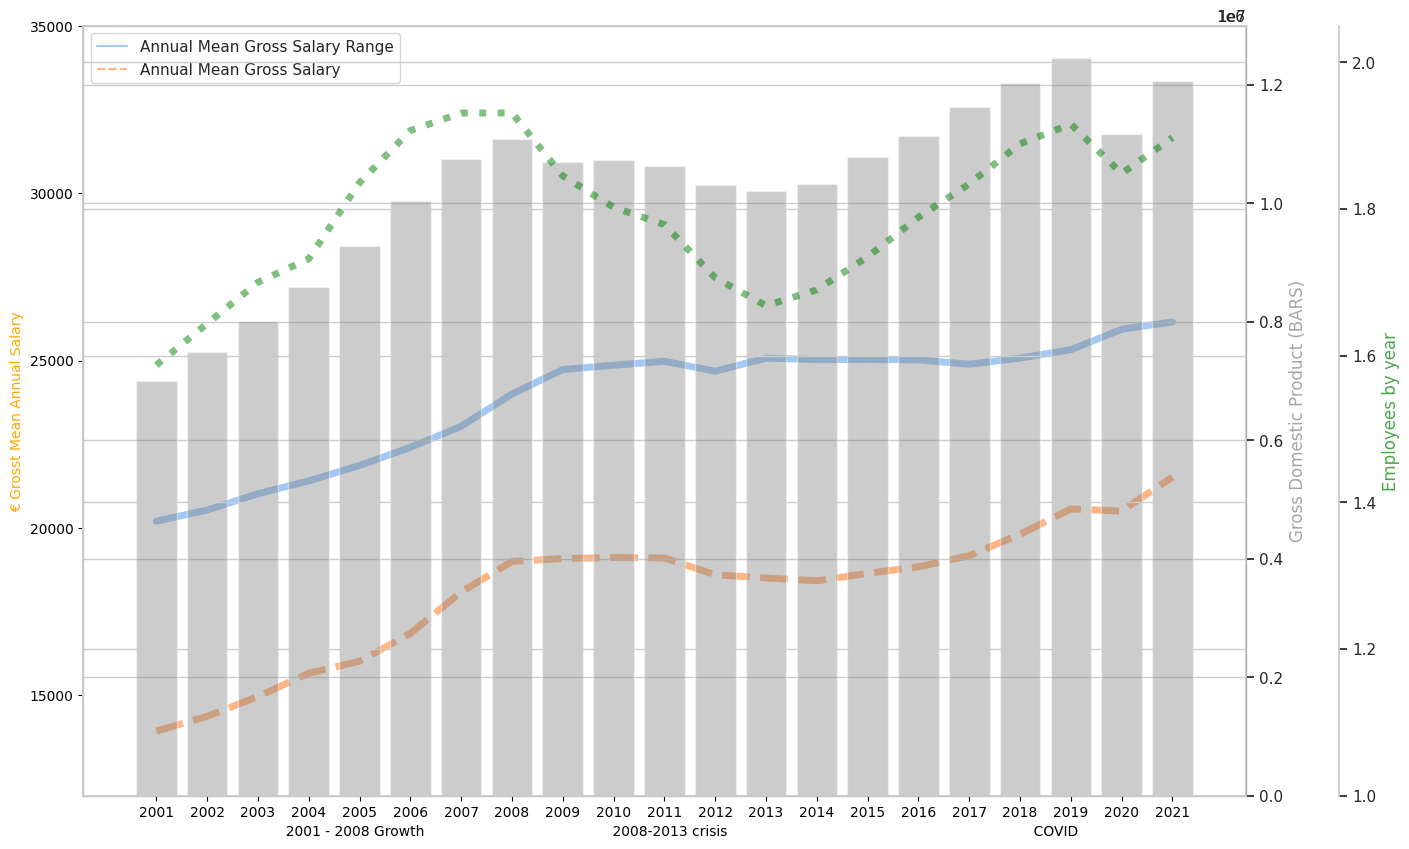

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_theme(style="whitegrid", palette="pastel")
sns.lineplot(data=macro.iloc[:,9:11], linewidth=5)                      # Para las líneas selecciono sólo columna 3 y 4 (ojo columna Unnamed)
ax.set_ylabel('€ Grosst Mean Annual Salary',  color='orange')
ax.set(title='',  xlabel='          2001 - 2008 Growth                                           2008-2013 crisis                                                                      COVID  ')
handles, labels = ax.get_legend_handles_labels()
mylabels = ['Annual Mean Gross Salary Range' , 'Annual Mean Gross Salary']          # Cambio el nombre de las etiquetas de la leyenda
ax.legend(handles, mylabels, title='', loc='upper left')  # Situación de la leyenda
ax.set(ylim=(12000, 35000))

ax2 = ax.twinx()                                                         # Añadir ax2 las barras
sns.barplot(data = macro, x='years', y='GDP', alpha=0.4, ax=ax2, color = 'Gray')
ax2.set_ylabel('Gross Domestic Product (BARS)', color = 'Gray', alpha = 0.7)
ax2.set(ylim=(0, 1300000))


ax3 = ax.twinx()                                                         # Añadir ax2 las barras
sns.lineplot(data=macro['employees'], linewidth=5, color = 'green', alpha = 0.5, ax=ax3, linestyle = 'dotted')
ax3.spines['right'].set_position(('axes', 1.08))
ax3.set_ylabel('Employees by year', color = 'green', alpha = 0.7)
ax3.set(ylim=(10000000, 20500000))



plt.show()



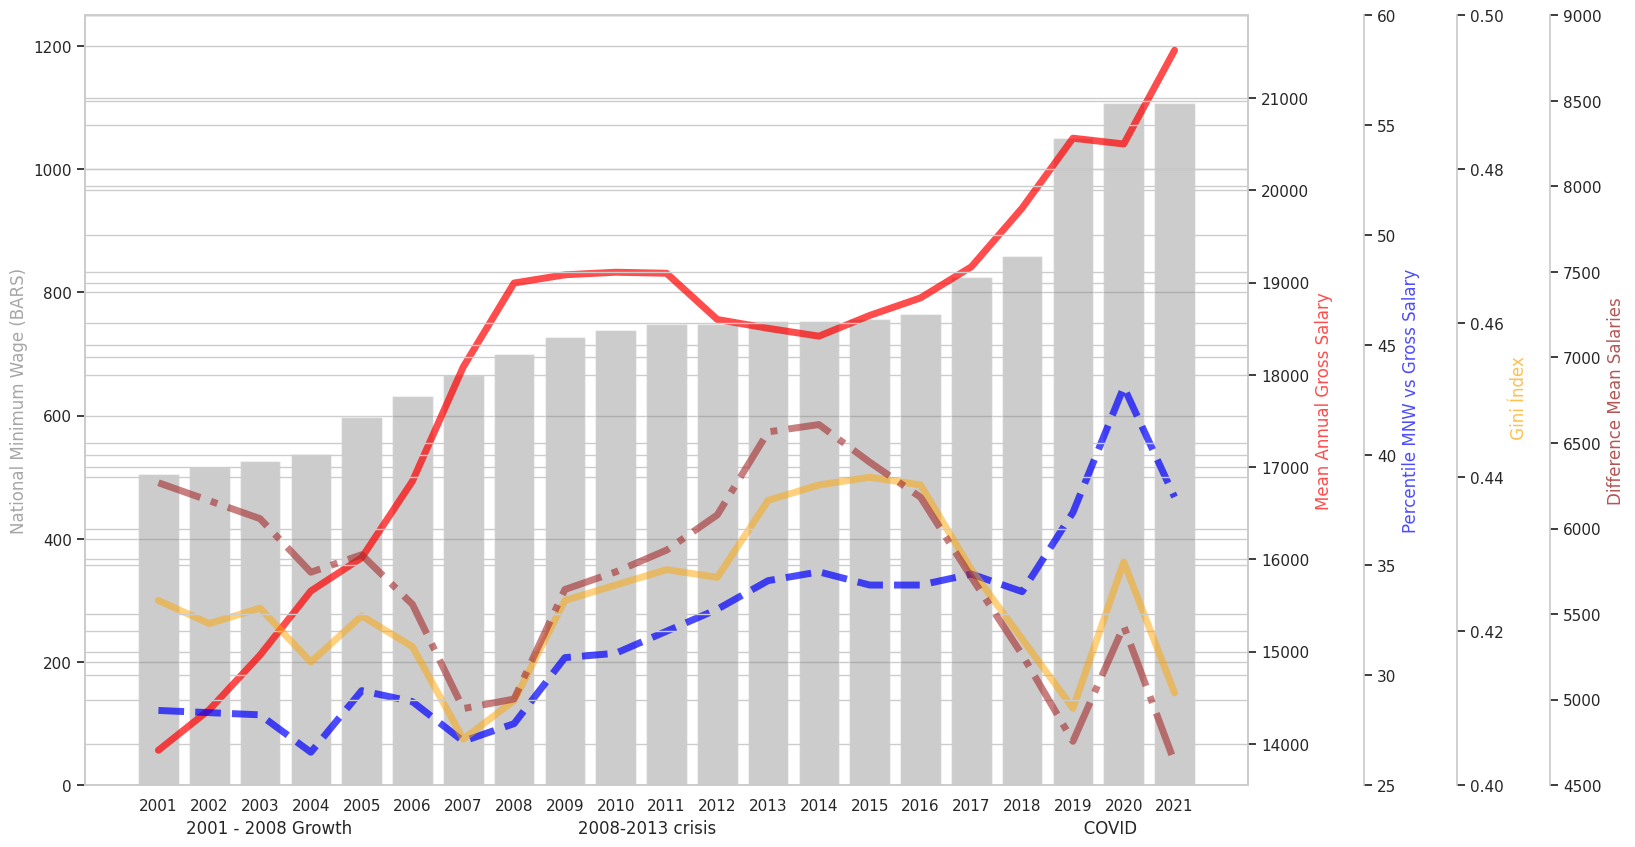

In [ ]:
afig, ax = plt.subplots(figsize=(15, 10))                                          #Se crea objeto fig, ax
sns.set_theme(style="whitegrid", palette="pastel")                                #Diseño
sns.barplot(data = macro, x='years', y='nmw', alpha=0.4, ax=ax, color = 'Gray')   #Gráfico de barras
ax.set(ylim=(0, 1250))                                                            #Límites para ajustar
ax.set(title='',  xlabel='2001 - 2008 Growth                                           2008-2013 crisis                                                                      COVID  ')
ax.set_ylabel('National Minimum Wage (BARS)', color = 'Gray', alpha = 0.7)

ax2 = ax.twinx()
sns.lineplot(data=macro['MeanSalary'], linewidth=5, ax=ax2, color = 'red' , alpha = 0.7)
ax2.set_ylabel('Mean Annual Gross Salary', color = 'red', alpha = 0.7)

ax3 = ax.twinx()                                                         # Añadir ax2 las barras
sns.lineplot(data=macro['Percentile'], linewidth=5, color = 'blue', alpha = 0.7, ax=ax3, linestyle = 'dashed')# Para bajar la situación de las barras
ax3.spines['right'].set_position(('axes', 1.1))
ax3.set_ylabel('Percentile MNW vs Gross Salary', color = 'blue', alpha = 0.7)
ax3.set(ylim=(25,60))

ax4 = ax.twinx()                                                         # Añadir ax2 las barras
sns.lineplot(data=macro['Netgini'], linewidth=5, ax=ax4, color = 'orange' , alpha = 0.5)   # Para bajar la situación de las barras
ax4.spines['right'].set_position(('axes', 1.18))
ax4.set_ylabel(' Gini Índex', color = 'orange', alpha = 0.7)
ax4.set(ylim=(0.4,0.5))

ax5 = ax.twinx()                                                         # Añadir ax2 las barras
sns.lineplot(data=macro['Diff'], linewidth=5, color = 'brown', alpha = 0.6, ax=ax5, linestyle = 'dashdot')
ax5.spines['right'].set_position(('axes', 1.26))
ax5.set_ylabel('Difference Mean Salaries', color = 'brown', alpha = 0.8)
ax5.set(ylim=(4500,9000))
fig.savefig('figura.png')

Text(0, 0.5, 'Difference Mean Salaries')

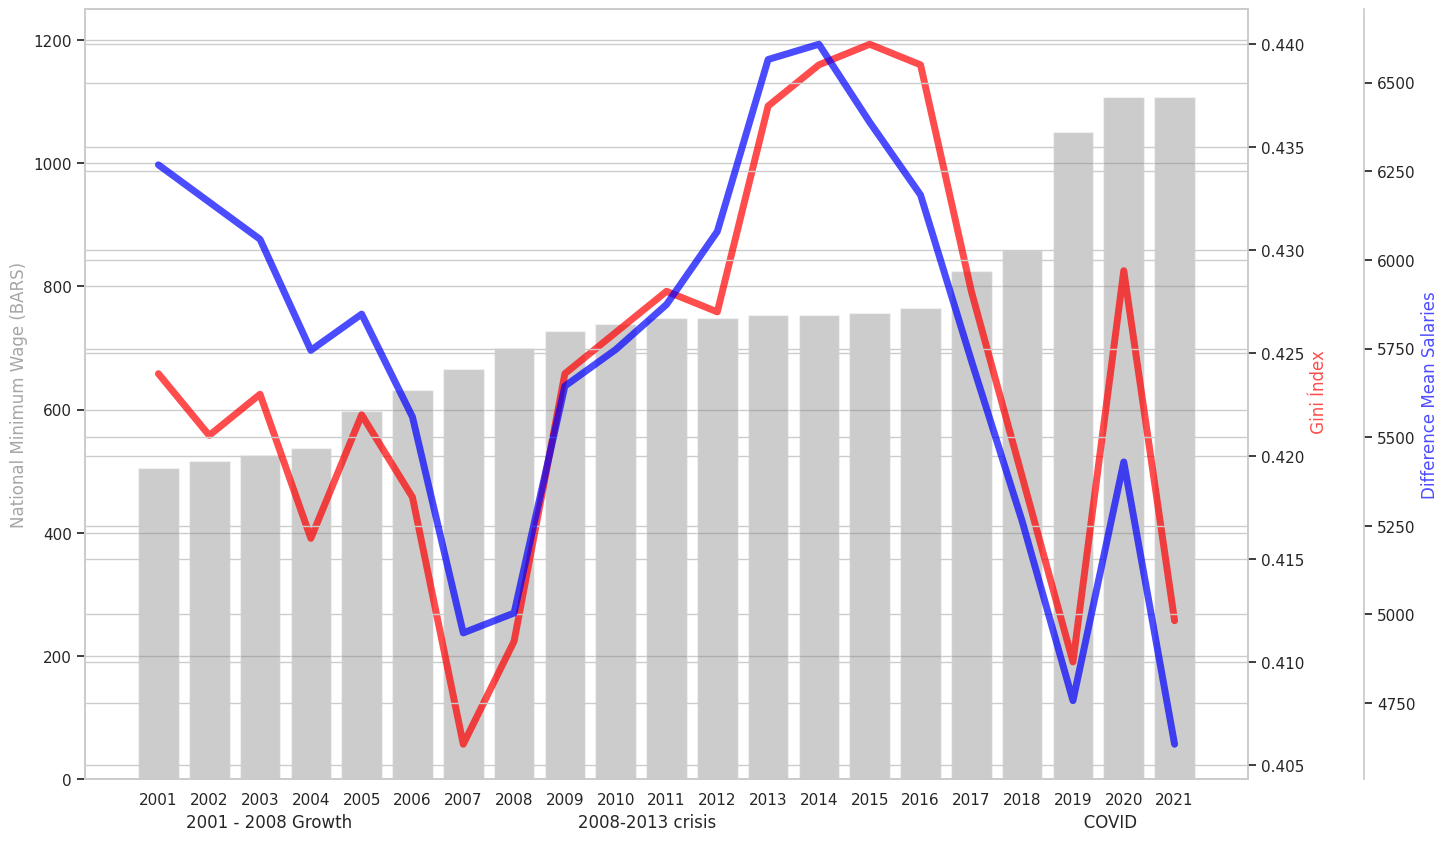

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))                                          #Se crea objeto fig, ax
sns.set_theme(style="whitegrid", palette="pastel")                                #Diseño
sns.barplot(data = macro, x='years', y='nmw', alpha=0.4, ax=ax, color = 'Gray')   #Gráfico de barras
ax.set(ylim=(0, 1250))                                                            #Límites para ajustar
ax.set(title='',  xlabel='2001 - 2008 Growth                                           2008-2013 crisis                                                                      COVID  ')
ax.set_ylabel('National Minimum Wage (BARS)', color = 'Gray', alpha = 0.7)
ax2 = ax.twinx()
sns.lineplot(data=macro['Netgini'], linewidth=5, ax=ax2, color = 'red' , alpha = 0.7)
ax2.set_ylabel(' Gini Índex', color = 'red', alpha = 0.7)


ax3 = ax.twinx()                                                         # Añadir ax2 las barras
                                             # Para bajar la situación de las barras
sns.lineplot(data=macro['Diff'], linewidth=5, color = 'blue', alpha = 0.7, ax=ax3)
ax3.spines['right'].set_position(('axes', 1.1))
ax3.set_ylabel('Difference Mean Salaries', color = 'blue', alpha = 0.7)

In [ ]:
# Creamos un gráfico para interpretar la estructura de Asalariados y total salarios por rangos
emp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFG/Employeesbyrange.csv', delimiter = ';')
inc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFG/IncomebyRange.csv', delimiter = ';')
df5 = emp.merge(inc, on=['Range10K', 'Years'])
df5['type1'] = 'Employees'
df5['type2'] = 'Incomes'
df51 = df5[['Range10K', 'Years', 'Employees', 'type1']]
df52 = df5[['Range10K', 'Years', 'Incomes', 'type2']]
df6 = df51
df52.columns = ['Range10K', 'Years', 'Employees', 'type1']
df6 = pd.concat([df6,df52])
df6.head()

,Range10K,Years,Employees,type1
0,0K,2021,10.727392,Employees
1,0K,2016,12.305097,Employees
2,0K,2001,13.335024,Employees
3,10K,2021,10.376957,Employees
4,10K,2016,9.700689,Employees


# Análisis EPA vs informe BdE

In [ ]:
EPA = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFG/EPA_edad.csv", delimiter=';')
EPA['TRIM'] = pd.PeriodIndex(EPA['trim'], freq='Q').to_timestamp()
EPA.head()

,trim,VALOR,EDAD,TRIM
0,2023-Q2,27.94,<25,2023-04-01
1,2023-Q1,30.03,<25,2023-01-01
2,2022-Q4,29.26,<25,2022-10-01
3,2022-Q3,31.01,<25,2022-07-01
4,2022-Q2,28.52,<25,2022-04-01


In [ ]:
EPA['TRIM'] = pd.PeriodIndex(EPA['trim'], freq='Q').to_timestamp()

In [ ]:
nmw = list(macro['nmw']) #Listado de SMI del 2001 - 2021
del nmw[0:1]  # Eliminamos el primero, pesto que EPA empieza en 2002
# Tenemos una lista anual, pero nos interesa una lista quatrimestral.
# Cada valor se ha de repetir 4 veces.
# Añadimos valores para 2022 y 2023
nmw.extend([1166, 1260])
# En este momento el orden es inverso a la dataset, invertimos el orden.
nmw.reverse()

In [ ]:
nmwT = []                            # Este es el vector trimestral.
count = 4                           # Repetimos todos los valores 4 veces (luego eliminamos los dos primeros ya que 2023 sólo hay 2 Q)
for element in nmw:
  for i in range(count):
        nmwT.append(element)
del nmwT[0:2]                         # Eliminamos los 2 primeros (que corresponden a Q3,Q4 2023).

In [ ]:
# Ahora para cuadrar para cada grupo de edad, 3 grupos, repetimos la lista
nmwT = nmwT *3
len(nmwT)

258

In [ ]:
# Ahora coincide la longitud del vector
EPA.shape

(258, 4)

In [ ]:
EPA['nmw'] = nmwT

In [ ]:
np.arange(1,5,1)

array([1, 2, 3, 4])

[[Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49, 0, ''),
  Text(50, 0, ''),
  Text(51, 0, ''),
  Text(52, 0, ''),
  T

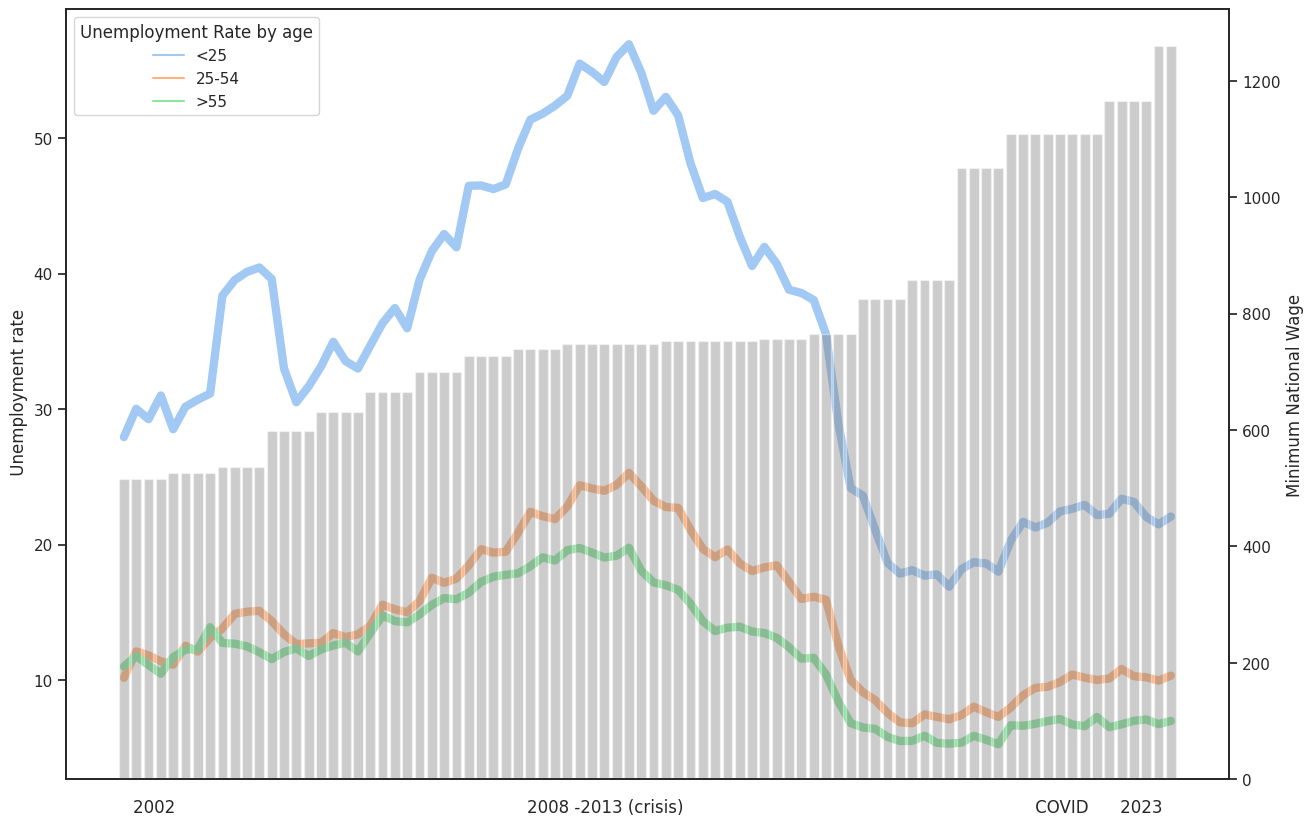

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()
sns.set_theme(style="white", palette=None)
sns.barplot(data = EPA[EPA['EDAD'] == '<25'].sort_values(by=['trim']), x='trim', y='nmw', alpha=0.4,  color = 'gray', ax = ax2)
sns.lineplot(data=EPA, x ='trim', y = 'VALOR', hue = 'EDAD', linewidth=6, ax = ax1)
handles, labels = ax.get_legend_handles_labels()
ax1.legend(title = 'Unemployment Rate by age', loc='upper left')  # Situación de la leyenda
ax1.set(ylabel= ' Unemployment rate', xlabel = '2002                                                                   2008 -2013 (crisis)                                                                   COVID      2023')
ax2.set(ylabel = 'Minimum National Wage')
ax1.set(xticklabels=[])  # remove the tick labels

# Regresión lineal GINI = x GDP + y MW

In [ ]:
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

In [ ]:
corr = macro.iloc[:,1:].corr(method = 'spearman')
corr.style.background_gradient(cmap='coolwarm')

,nmw,Grossgini,Netgini,employees,uneRate,Pdebt,Pdebt_GDP,GDP,MeanSalaryR,MeanSalary,Diff,IPC,taxes,Percentile
nmw,1.000000,0.393940,0.276513,0.363991,0.527137,0.988626,0.821580,0.876828,0.963926,0.878778,-0.279493,0.485371,0.798180,0.896619
Grossgini,0.393940,1.000000,0.980777,-0.513023,0.806643,0.406251,0.703127,0.053386,0.389324,0.137370,0.692060,0.476719,-0.002604,0.571151
Netgini,0.276513,0.980777,1.000000,-0.570686,0.754631,0.291193,0.625285,-0.057849,0.280143,0.031849,0.753982,0.422627,-0.108547,0.475618
employees,0.363991,-0.513023,-0.570686,1.000000,-0.428571,0.324675,-0.176623,0.677922,0.323377,0.572727,-0.890909,-0.107827,0.623377,0.066255
uneRate,0.527137,0.806643,0.754631,-0.428571,1.000000,0.541558,0.714286,0.211688,0.561039,0.350649,0.524675,0.320234,0.237662,0.643066
Pdebt,0.988626,0.406251,0.291193,0.324675,0.541558,1.000000,0.837662,0.844156,0.949351,0.864935,-0.245455,0.499513,0.762338,0.912634
Pdebt_GDP,0.821580,0.703127,0.625285,-0.176623,0.714286,0.837662,1.000000,0.529870,0.806494,0.580519,0.203896,0.622930,0.455844,0.912634
GDP,0.876828,0.053386,-0.057849,0.677922,0.211688,0.844156,0.529870,1.000000,0.810390,0.914286,-0.584416,0.328678,0.857143,0.632673
MeanSalaryR,0.963926,0.389324,0.280143,0.323377,0.561039,0.949351,0.806494,0.810390,1.000000,0.844156,-0.227273,0.393634,0.777922,0.880806
MeanSalary,0.878778,0.137370,0.031849,0.572727,0.350649,0.864935,0.580519,0.914286,0.844156,1.000000,-0.548052,0.372848,0.938961,0.702176


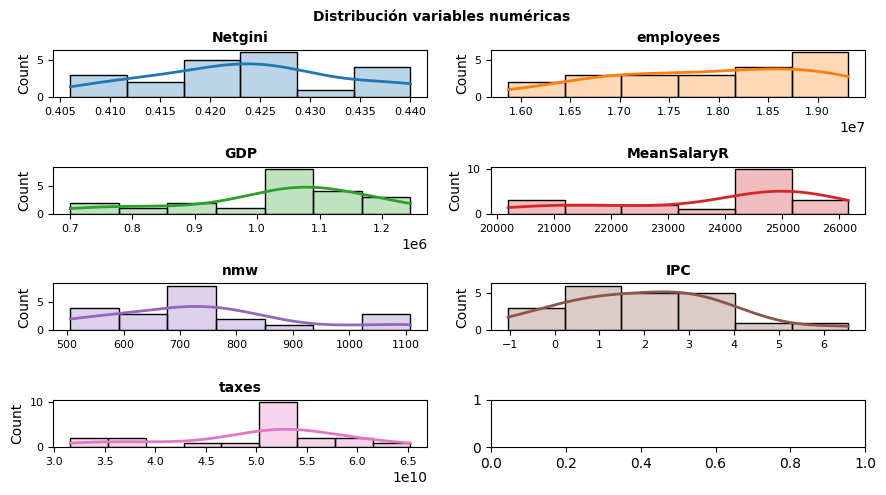

In [ ]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(9, 5))
axes = axes.flat
columnas = ['Netgini', 'employees', 'GDP', 'MeanSalaryR', 'nmw', 'IPC', 'taxes']

for i, colum in enumerate(columnas):
    sns.histplot(
        data    = macro,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")



fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

In [ ]:
y = macro[['Netgini']]
x = macro[[ 'employees',   'Pdebt', 'GDP', 'MeanSalaryR', 'MeanSalary',
       'Diff', 'IPC', 'taxes']]

In [ ]:
# with statsmodels
x = sm.add_constant(x) # adding a constant

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                Netgini   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     246.7
Date:                Sun, 06 Aug 2023   Prob (F-statistic):           8.64e-13
Time:                        07:44:40   Log-Likelihood:                 119.29
No. Observations:                  21   AIC:                            -222.6
Df Residuals:                      13   BIC:                            -214.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1112      0.021      5.372      

# Graph Correlation

In [ ]:
cols = ['nmw',  'Netgini', 'employees',               # Lista de las columnas que quiero evaluar las correlaciones
       'uneRate', 'Pdebt',  'GDP', 'MeanSalaryR',
        'IPC', 'taxes', 'Diff']
comb = list(itertools.combinations(cols, 2))          # Pares para las correlaciones
comb[:3]                                              # comb es un listado de todos los pares posibles

[('nmw', 'Netgini'), ('nmw', 'employees'), ('nmw', 'uneRate')]

In [ ]:
from scipy.stats import spearmanr
spearmanr(macro[comb[0][0]], macro[comb[0][1]])[0]

0.27651268705270005

In [ ]:
res = []
for n in range(len(comb)):
  p = comb[n][0]
  q = comb[n][1]
  res.append([p,q,spearmanr(macro[p], macro[q])[0]])


In [ ]:
graph = pd.DataFrame(res, columns = ['Var1', 'Var2', 'Rho'])     # Elaboramos la dataset con los resultados Spearman para cada pareja.
graph.sort_values('Rho', ascending = False)

,Var1,Var2,Rho
3,nmw,Pdebt,0.988626
5,nmw,MeanSalaryR,0.963926
31,Pdebt,MeanSalaryR,0.949351
4,nmw,GDP,0.876828
37,GDP,taxes,0.857143
30,Pdebt,GDP,0.844156
35,GDP,MeanSalaryR,0.810390
7,nmw,taxes,0.798180
40,MeanSalaryR,taxes,0.777922
33,Pdebt,taxes,0.762338


In [ ]:
graph = graph[abs(graph['Rho']) > 0.5]                                 # Sólo adjunto Spearman > 0.5

In [ ]:
graph

,Var1,Var2,Rho
2,nmw,uneRate,0.527137
3,nmw,Pdebt,0.988626
4,nmw,GDP,0.876828
5,nmw,MeanSalaryR,0.963926
7,nmw,taxes,0.798180
9,Netgini,employees,-0.570686
10,Netgini,uneRate,0.754631
16,Netgini,Diff,0.753982
19,employees,GDP,0.677922
22,employees,taxes,0.623377


In [ ]:
# Preparamos el archivo para lectura con Gephi
graph.columns = ['Source', 'Target', 'Rho']
graph.dtypes

Source     object
Target     object
Rho       float64
dtype: object

In [ ]:
graph['Type'] = 'Undirected'

In [ ]:
graph['Id'] = np.arange(1, graph.shape[0]+1, 1)  # Id comienza por 1

In [ ]:
graph

,Source,Target,Rho,Type,Id
2,nmw,uneRate,0.527137,Undirected,1
3,nmw,Pdebt,0.988626,Undirected,2
4,nmw,GDP,0.876828,Undirected,3
5,nmw,MeanSalaryR,0.963926,Undirected,4
7,nmw,taxes,0.798180,Undirected,5
9,Netgini,employees,-0.570686,Undirected,6
10,Netgini,uneRate,0.754631,Undirected,7
16,Netgini,Diff,0.753982,Undirected,8
19,employees,GDP,0.677922,Undirected,9
22,employees,taxes,0.623377,Undirected,10


In [ ]:
graph.to_csv("/content/drive/MyDrive/Colab Notebooks/TFG/graph.csv")   # Exporto para elaborar visualización con Gephi.

In [ ]:
graph.sort_values('Rho', ascending = False)

,Source,Target,Rho,Type,Id
3,nmw,Pdebt,0.988626,Undirected,2
5,nmw,MeanSalaryR,0.963926,Undirected,4
31,Pdebt,MeanSalaryR,0.949351,Undirected,16
4,nmw,GDP,0.876828,Undirected,3
37,GDP,taxes,0.857143,Undirected,19
30,Pdebt,GDP,0.844156,Undirected,15
35,GDP,MeanSalaryR,0.810390,Undirected,18
7,nmw,taxes,0.798180,Undirected,5
40,MeanSalaryR,taxes,0.777922,Undirected,21
33,Pdebt,taxes,0.762338,Undirected,17


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

In [ ]:
y = macro[['Netgini']]
x = macro[[ 'employees',   'Pdebt', 'GDP', 'MeanSalaryR', 'MeanSalary',
       'Diff', 'IPC', 'taxes']]

In [ ]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        x,
                                        y.iloc[:,0],   # Se pide un vector
                                        random_state = 123
                                    )
# Creación del modelo
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = None,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

RandomForestRegressor(max_features=None, n_estimators=10, n_jobs=-1,
                      random_state=123)

In [ ]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.003146691384083722


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Valor óptimo de n_estimators: 126


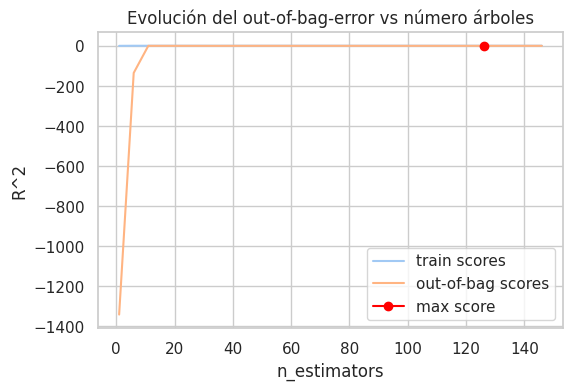

In [ ]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = None,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

Valor óptimo de n_estimators: 160


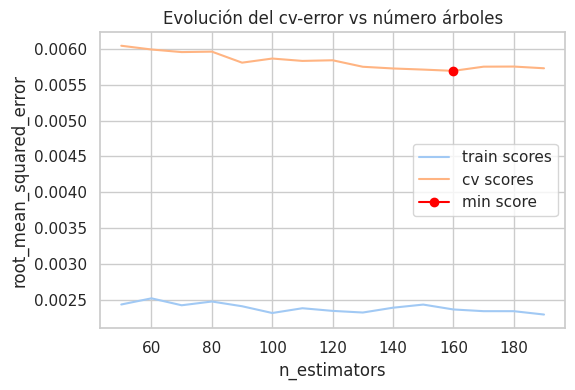

In [ ]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados, mirar antes indica 126
estimator_range = range(50, 200, 10)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:

    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = None,
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )

    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Valor óptimo de max_features: 5


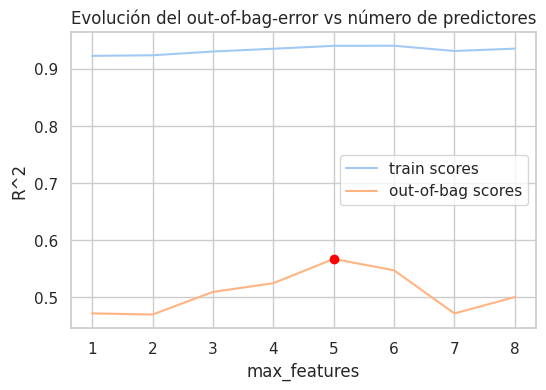

In [ ]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 71,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:

    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )

    modelo.fit(X_train, y_train)

    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 9, 'n_estimators': 150} ✓


,oob_r2,max_depth,max_features,n_estimators
0,0.524070,NaN,5.0,150.0
6,0.524070,10.0,5.0,150.0
9,0.524070,20.0,5.0,150.0
3,0.517739,3.0,5.0,150.0


In [ ]:
# VERSIÓN PARALELIZADA
# ==============================================================================

# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop paralelizado para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
def eval_oob_error(X, y, modelo, params, verbose=True):
    """
    Función para entrenar un modelo utilizando unos parámetros determinados
    y que devuelve el out-of-bag error
    """
    modelo.set_params(
        oob_score    = True,
        n_jobs       = -1,
        random_state = 123,
        ** params
    )

    modelo.fit(X, y)

    if verbose:
        print(f"Modelo: {params} \u2713")

    return{'params': params, 'oob_r2': modelo.oob_score_}


n_jobs     = multiprocessing.cpu_count() -1
pool       = multiprocessing.Pool(processes=n_jobs)
resultados = pool.starmap(
                eval_oob_error,
                [(X_train, y_train, RandomForestRegressor(), params) for params in param_grid]
             )

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 9, 'n_estimators': 150} ✓


,oob_r2,max_depth,max_features,n_estimators
0,0.524070,NaN,5.0,150.0
6,0.524070,10.0,5.0,150.0
9,0.524070,20.0,5.0,150.0
3,0.517739,3.0,5.0,150.0


In [ ]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.5240698799990651 : 0.5240698799990651 R2


In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
0,None,5,150,-0.006141,0.002630,-0.002429,0.000171
6,10,5,150,-0.006141,0.002630,-0.002429,0.000171
9,20,5,150,-0.006141,0.002630,-0.002429,0.000171
3,3,5,150,-0.006181,0.002626,-0.002535,0.000170


In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': None, 'max_features': 5, 'n_estimators': 150} : -0.006141350897519322 neg_root_mean_squared_error


In [ ]:
var = ['Employees', 'DEBT', 'GDP', 'Mean Salary Range', 'Mean Salary', 'Diff', 'CPI',
       'TAXES']

In [ ]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.0039260969215030245


In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': var,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
5,Diff,0.580703
0,Employees,0.233568
1,DEBT,0.084700
3,Mean Salary Range,0.032971
6,CPI,0.028312
7,TAXES,0.019444
2,GDP,0.014049
4,Mean Salary,0.006253


In [ ]:
X_train.columns

Index(['employees', 'Pdebt', 'GDP', 'MeanSalaryR', 'MeanSalary', 'Diff', 'IPC',
       'taxes'],
      dtype='object')

In [ ]:
importancia = permutation_importance(
                estimator    = modelo,   # Ojo que aquí puedes coger el modelo inicial que el final (inicial con menor mse)
                X            = X_train,
                y            = y_train,
                n_repeats    = 20,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = var
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
5,0.005843,0.001300,Diff
0,0.001905,0.000633,Employees
1,0.000862,0.000425,DEBT
6,0.000291,0.000140,CPI
3,0.000265,0.000121,Mean Salary Range
2,0.000135,0.000103,GDP
7,0.000071,0.000067,TAXES
4,0.000055,0.000050,Mean Salary


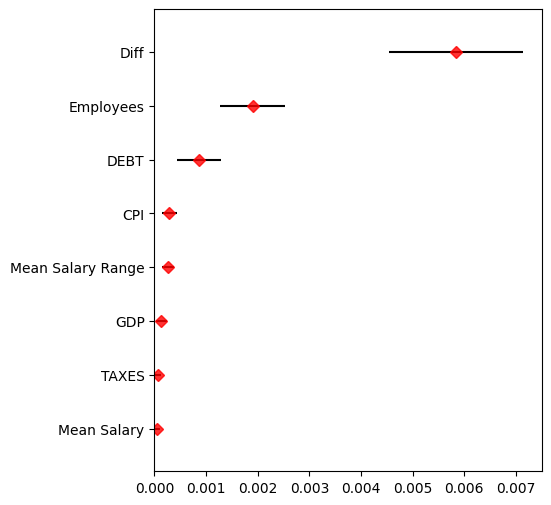

In [ ]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
#ax.set_title('Importancia de los predictores (train)')
#ax.set_xlabel('Incremento del error tras la permutación');

[Text(0.5555555555555556, 0.9285714285714286, 'x[5] <= 6416.5\nsquared_error = 0.0\nsamples = 10\nvalue = 0.427'),
 Text(0.3333333333333333, 0.7857142857142857, 'x[5] <= 5032.0\nsquared_error = 0.0\nsamples = 8\nvalue = 0.425'),
 Text(0.2222222222222222, 0.6428571428571429, 'squared_error = 0.0\nsamples = 1\nvalue = 0.412'),
 Text(0.4444444444444444, 0.6428571428571429, 'x[7] <= 52965279744.0\nsquared_error = 0.0\nsamples = 7\nvalue = 0.426'),
 Text(0.2222222222222222, 0.5, 'x[6] <= -0.14\nsquared_error = 0.0\nsamples = 4\nvalue = 0.423'),
 Text(0.1111111111111111, 0.35714285714285715, 'squared_error = 0.0\nsamples = 1\nvalue = 0.421'),
 Text(0.3333333333333333, 0.35714285714285715, 'x[0] <= 16436392.5\nsquared_error = 0.0\nsamples = 3\nvalue = 0.424'),
 Text(0.2222222222222222, 0.21428571428571427, 'squared_error = 0.0\nsamples = 1\nvalue = 0.424'),
 Text(0.4444444444444444, 0.21428571428571427, 'x[5] <= 5851.0\nsquared_error = 0.0\nsamples = 2\nvalue = 0.423'),
 Text(0.33333333333333

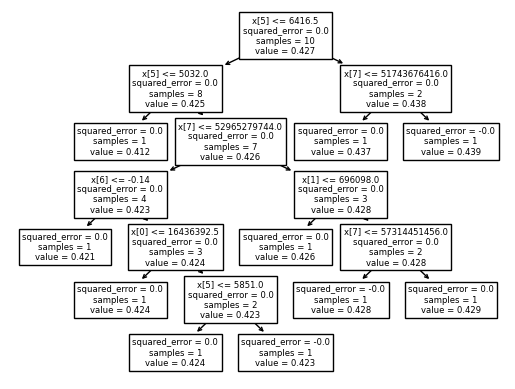

In [ ]:
from sklearn import tree
tree.plot_tree(modelo.estimators_[0])

In [ ]:
modelo_final.estimators_[0]

DecisionTreeRegressor(max_features=5, random_state=843828734)

# Evaluar analizar AUTOREGRESSIVE DISTRIBUTED LAG (ARDL) MODEL

https://www.kaggle.com/code/datascientistsohail/autoregressive-distributed-lag-ardl-model

https://youtu.be/9YQK8RDrzoM

https://github.com/Natsiopoulos/ARDL




In [ ]:
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.ardl.ARDL.html
from statsmodels.tsa.api import ARDL
from statsmodels.datasets import danish_data


In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
# Son estacionarias las variables?
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [ ]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [ ]:
# Para un p-value > 0.05 la variable NO es estacionaria.
for c in columnas:
  print('###########', c)
  adf_test(macro[c])
  kpss_test(macro[c])

########### Netgini
Results of Dickey-Fuller Test:
Test Statistic                 -1.932135
p-value                         0.317098
#Lags Used                      0.000000
Number of Observations Used    20.000000
Critical Value (1%)            -3.809209
Critical Value (5%)            -3.021645
Critical Value (10%)           -2.650713
dtype: float64
Results of KPSS Test:
Test Statistic           0.180174
p-value                  0.100000
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
########### employees
Results of Dickey-Fuller Test:
Test Statistic                 -2.181457
p-value                         0.213044
#Lags Used                      6.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64
Results of KPSS T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Test Statistic           0.720449
p-value                  0.011686
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
########### IPC
Results of Dickey-Fuller Test:
Test Statistic                 -0.338080
p-value                         0.919935
#Lags Used                      4.000000
Number of Observations Used    16.000000
Critical Value (1%)            -3.924019
Critical Value (5%)            -3.068498
Critical Value (10%)           -2.673893
dtype: float64
Results of KPSS Test:
Test Statistic           0.365318
p-value                  0.092104
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
########### taxes
Results of Dickey-Fuller Test:
Test Statistic                 -1.412328
p-value                         0

In [ ]:
# trend:
  #‘n’ - No trend.
  #‘c’ - Constant only.
  #‘t’ - Time trend only.
  #‘ct’ - Constant and time trend.
endog = y
lags = 3
exog = x
model = ARDL(endog, lags, exog, order=0, trend='t', fixed=None, causal=False, seasonal=False, deterministic=None, hold_back=None, period=None, missing='none').fit()

In [ ]:
print(model.summary())

                                     ARDL Model Results                                    
Dep. Variable:                             Netgini   No. Observations:                   21
Model:             ARDL(3, 0, 0, 0, 0, 0, 0, 0, 0)   Log Likelihood                 107.849
Method:                            Conditional MLE   S.D. of innovations              0.001
Date:                             Tue, 08 Aug 2023   AIC                           -189.699
Time:                                     08:05:05   BIC                           -178.124
Sample:                                          3   HQIC                          -188.103
                                                21                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
trend              0.0015      0.001      1.086      0.319      -0.002       0.005
Netgini.L1     